In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product h.csv', parse_dates=['Month-Year'])

In [3]:
sales_h= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [4]:
sales_h.shape

(60, 2)

In [5]:
sales_h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month-Year  60 non-null     datetime64[ns]
 1   Sales       60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [6]:
sales_h['Sales'].sum()

4057933

In [7]:
sales_h = sales_h.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_h.head()

ds      y
0 2019-01-01  62686
1 2019-02-01  74426
2 2019-03-01  91347
3 2019-04-01  60600
4 2019-05-01  37374

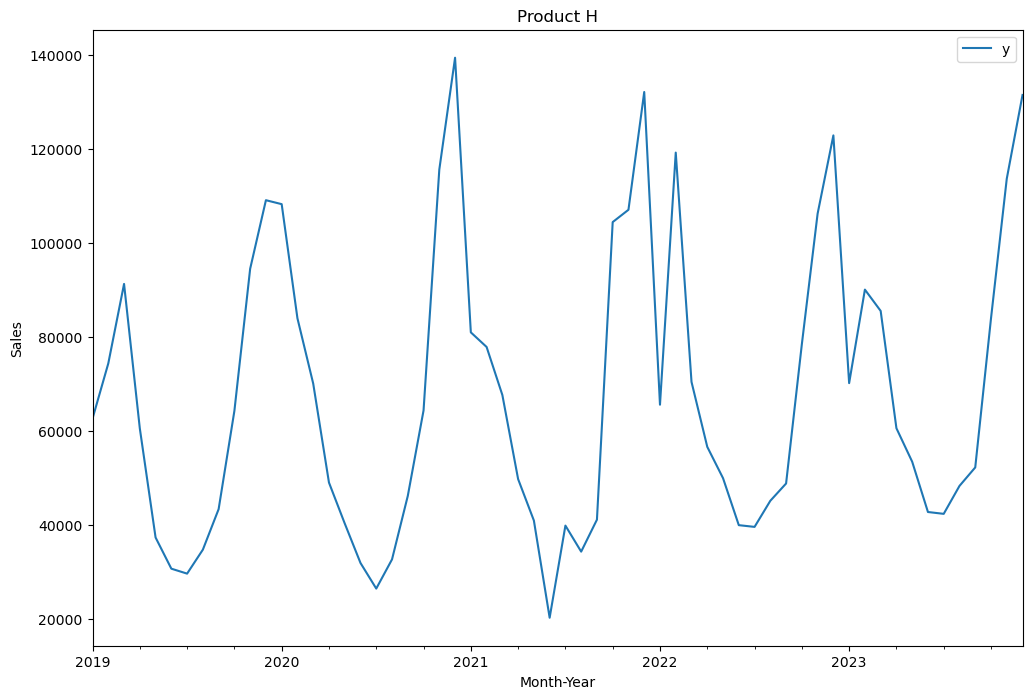

In [8]:
ax = sales_h.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product H')
plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_test(sales_h['y'])

ADF Statistics: -1.0256008967536312
p- value: 0.7438128320877682
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
train= sales_h[:57]
test=sales_h[57:]

# Hyperparameter Tuning

In [13]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:27:23 - cmdstanpy - INFO - Chain [1] start processing
15:27:24 - cmdstanpy - INFO - Chain [1] done processing
15:27:38 - cmdstanpy - INFO - Chain [1] start processing
15:27:38 - cmdstanpy - INFO - Chain [1] done processing
15:27:54 - cmdstanpy - INFO - Chain [1] start processing
15:27:55 - cmdstanpy - INFO - Chain [1] done processing
15:27:59 - cmdstanpy - INFO - Chain [1] start processing
15:27:59 - cmdstanpy - INFO - Chain [1] done processing
15:28:04 - cmdstanpy - INFO - Chain [1] start processing
15:28:04 - cmdstanpy - INFO - Chain [1] done processing
15:28:11 - cmdstanpy - INFO - Chain [1] start processing
15:28:14 - cmdstanpy - INFO - Chain [1] done processing
15:28:21 - cmdstanpy - INFO - Chain [1] start processing
15:28:21 - cmdstanpy - INFO - Chain [1] done processing
15:28:29 - cmdstanpy - INFO - Chain [1] start processing
15:28:30 - cmdstanpy - INFO - Chain [1] done processing
15:28:35 - cmdstanpy - INFO - Chain [1] start processing
15:28:38 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

            rmse  
0   34934.136657  
1   35740.521000  
2   12467.406436  
3   12825.118073  
4   12451.478390  
..       

In [14]:
tuning_results.sort_values('rmse',ascending=True)

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
26                    0.100                     0.10         additive   
14                    0.010                     0.10         additive   
4                     0.001                     1.00         additive   
6                     0.001                     3.00         additive   
2                     0.001                     0.10         additive   
..                      ...                      ...              ...   
25                    0.100                     0.01   multiplicative   
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
60                    0.500                     0.01         additive   
61                    0.500                     0.01   multiplicative   

            rmse  
26  12315.246089  
14  12340.362134  
4   12451.478390  
6   12451.694933  
2   12467.406436  
..           ...  
25  34160.928821  
0   34934.136657  
1   35740.521000  
60  37948.124241  
61  38370.211186  

[72 rows x 4 columns]

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}


In [16]:
# Create a Prophet model
model = Prophet( changepoint_prior_scale= 0.100,seasonality_prior_scale=0.10,seasonality_mode = 'additive',
                interval_width=0.95)

In [17]:
model.fit(train)

15:43:43 - cmdstanpy - INFO - Chain [1] start processing
15:43:43 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
len(test)

3

In [19]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [20]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [21]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [22]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
57 2023-10-01   84584.471761   65793.579747  104516.798010
58 2023-11-01  111625.079186   93766.569103  129474.552096
59 2023-12-01  130419.393348  112729.363103  149934.107695

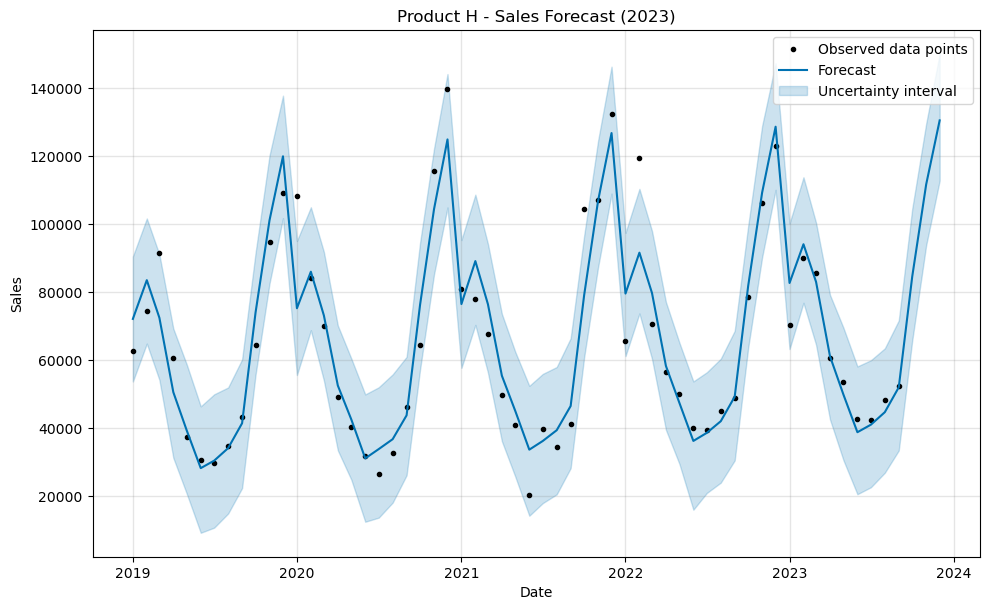

In [23]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product H - Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

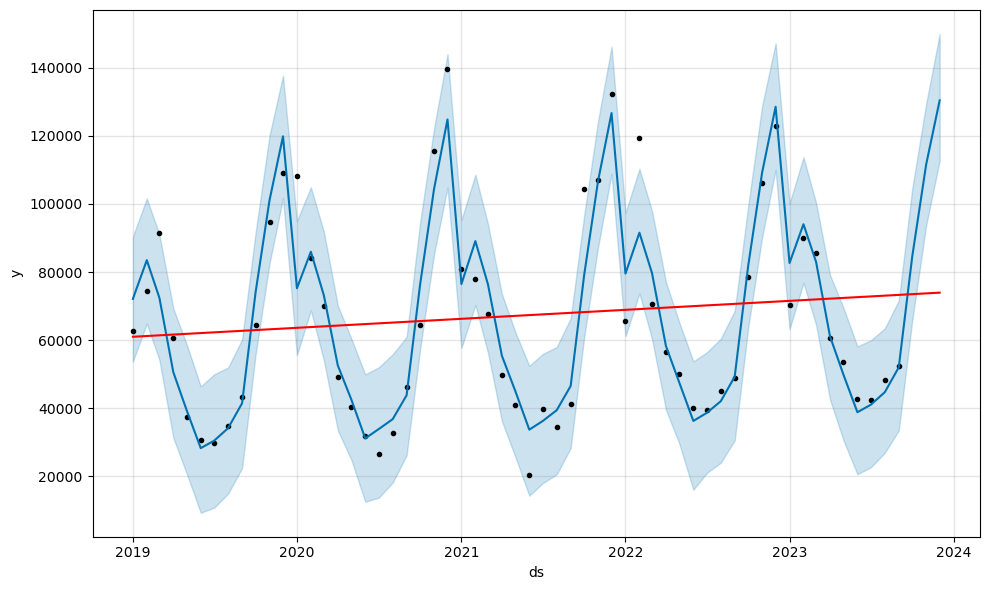

In [24]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

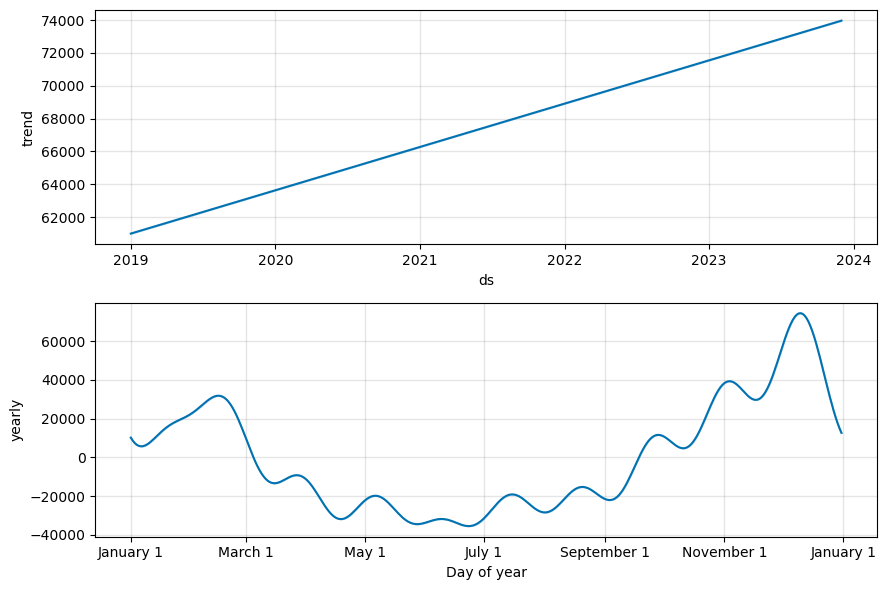

In [25]:
fig2 = model.plot_components(forecast)

In [26]:
forecasted_df

ds           yhat     yhat_lower     yhat_upper
57 2023-10-01   84584.471761   65793.579747  104516.798010
58 2023-11-01  111625.079186   93766.569103  129474.552096
59 2023-12-01  130419.393348  112729.363103  149934.107695

In [27]:
sales_h.tail(3) 

ds       y
57 2023-10-01   84019
58 2023-11-01  113741
59 2023-12-01  131572

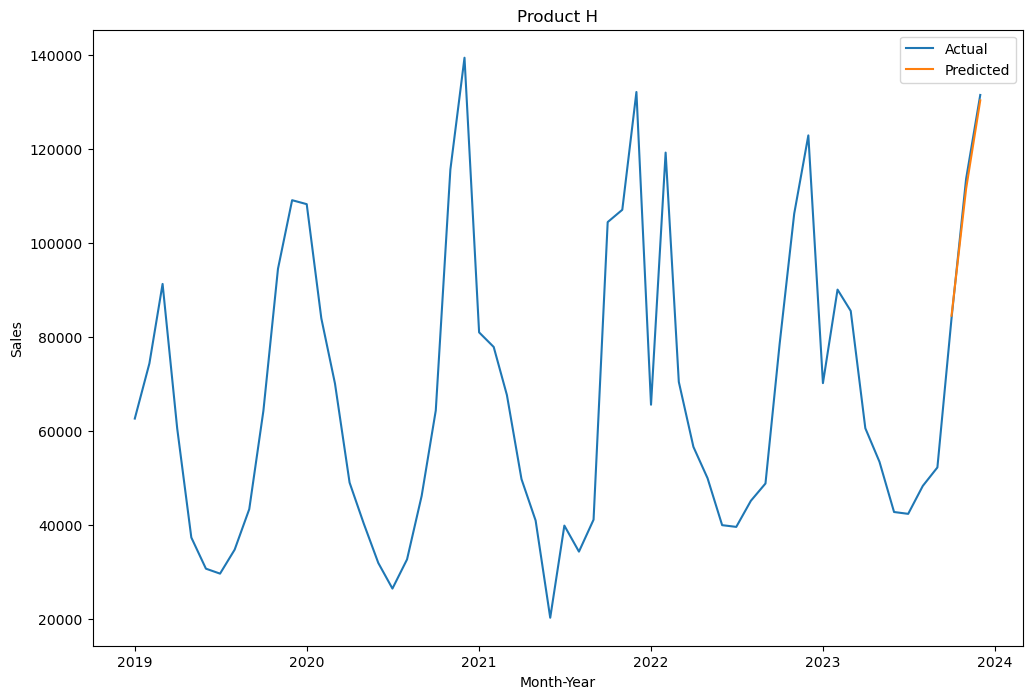

In [28]:
# Reset index of sales_b DataFrame
sales_h_reset_index = sales_h.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_h_reset_index['ds'], sales_h_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product H')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [29]:
#model evaluation

In [30]:
pred=forecasted_df['yhat']
test_df=test['y']

In [31]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 1278.000
MAPE - FB PROPHET: 0.011
MSE - FB PROPHET: 2041793.765
RMSE - FB PROPHET: 1428.913


In [32]:
# train data: 0 to 47 --> Jan-2019 to Dec-2022
# test data: 48: 59 --> Jan 2023 to Dec-2023

#sales_b['y'].plot(figsize=(12,8))
#forecast_df['yhat'].plot()
#plt.title('Product B')
#plt.xlabel('Month')
#plt.ylabel('Sales')
#plt.legend(labels=['Actual', 'Predicted'])
#plt.show()

# Cross Validation

In [33]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [34]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0  20 days  5.771354e+08  24023.643208  19399.508475  0.268475  0.257240   
1  22 days  6.933582e+08  26331.695867  21666.650403  0.257903  0.346988   
2  23 days  1.756970e+08  13255.076274   8755.910786  0.137928  0.049598   
3  25 days  9.752928e+07   9875.691535   6280.718019  0.094616  0.068357   
4  27 days  9.097523e+07   9538.093744   7099.050966  0.098622  0.068357   
5  28 days  8.272652e+07   9095.412152   5981.854088  0.091682  0.047536   
6  47 days  4.341089e+07   6588.694054   4002.760322  0.070254  0.047536   
7  49 days  2.882567e+06   1697.812522   1577.038868  0.039006  0.047536   
8  51 days  2.529987e+06   1590.593168   1483.010386  0.028555  0.020010   
9  52 days  6.503332e+06   2550.163046   2141.784866  0.038757  0.020010   
10 53 days  4.302700e+08  20742.951228  13799.871948  0.131726  0.080077   
11 54 days  4.357494e+08  20874.612507  14691.792267  0.158858  0.097581   
12 56 days  4.378897e+08  20925.813150  14936.606219  0.147024  0.097581   
13 57 days  2.429127e+07   4928.617039   4904.554195  0.082063  0.097581   
14 58 days  2.614981e+07   5113.688766   5102.028625  0.068033  0.055492   
15 59 days  2.678503e+07   5175.425397   5167.693311  0.087199  0.102070   
16 78 days  9.392074e+07   9691.271202   8393.828906  0.302860  0.102070   
17 80 days  9.257204e+07   9621.436424   8253.071644  0.321445  0.111245   
18 81 days  7.215012e+07   8494.122422   8011.502940  0.111501  0.111245   
19 83 days  7.562210e+07   8696.096941   8352.482118  0.121108  0.140067   
20 85 days  4.364474e+07   6606.416423   5557.991510  0.093065  0.140067   
21 86 days  2.687628e+07   5184.234094   4278.425256  0.044124  0.037572   
22 88 days  3.813112e+07   6175.040328   5818.490264  0.081406  0.067298   
23 90 days  2.512798e+07   5012.781566   4114.591924  0.067969  0.037572   

       smape  coverage  
0   0.305850  0.666667  
1   0.269614  0.333333  
2   0.120477  0.666667  
3   0.085162  0.833333  
4   0.090453  1.000000  
5   0.084652  1.000000  
6   0.066534  1.000000  
7   0.038928  1.000000  
8   0.028135  1.000000  
9   0.039848  1.000000  
10  0.150392  0.666667  
11  0.179149  0.666667  
12  0.165877  0.666667  
13  0.085310  1.000000  
14  0.069113  1.000000  
15  0.090432  1.000000  
16  0.235849  1.000000  
17  0.252979  1.000000  
18  0.106074  1.000000  
19  0.121151  1.000000  
20  0.094721  1.000000  
21  0.043509  1.000000  
22  0.084394  1.000000  
23  0.071227  1.000000

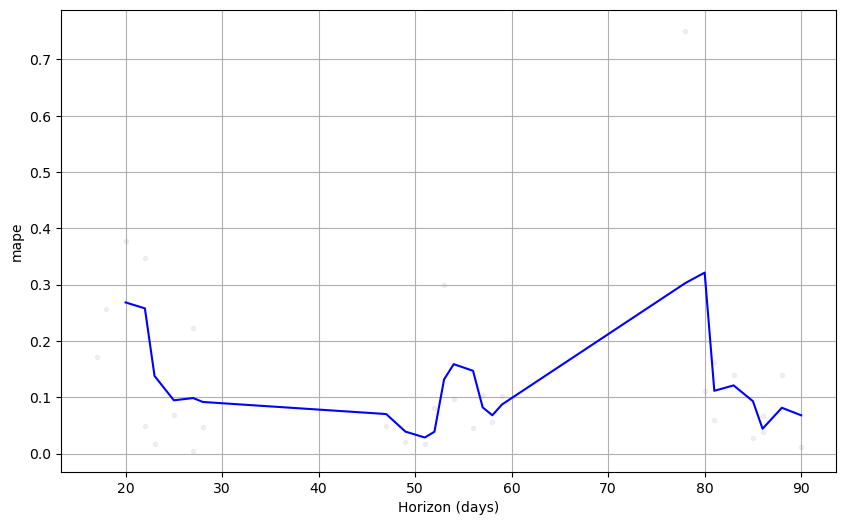

In [35]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [36]:
print(pred)

57     84584.471761
58    111625.079186
59    130419.393348
Name: yhat, dtype: float64


In [37]:
print(test_df)

57     84019
58    113741
59    131572
Name: y, dtype: int64


# FORECASTING

In [38]:
model_forecast = Prophet( changepoint_prior_scale= 0.100,seasonality_prior_scale=0.10,seasonality_mode = 'additive',
                interval_width=0.95)

In [39]:
model_forecast.fit(sales_h)

15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Create a DataFrame for future dates 
future_dates_f = model_forecast.make_future_dataframe(periods=3, freq='MS')  # 3 months in 2024

In [41]:
# Make predictions for the future
forecast_f = model_forecast.predict(future_dates_f)

In [42]:
forecasted_f_df=forecast_f[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [43]:
forecasted_f_df

ds          yhat    yhat_lower     yhat_upper
60 2024-01-01  85971.026019  67379.290528  103824.754059
61 2024-02-01  96629.654130  78813.033588  114591.828590
62 2024-03-01  83762.748405  66409.552818  102172.419813

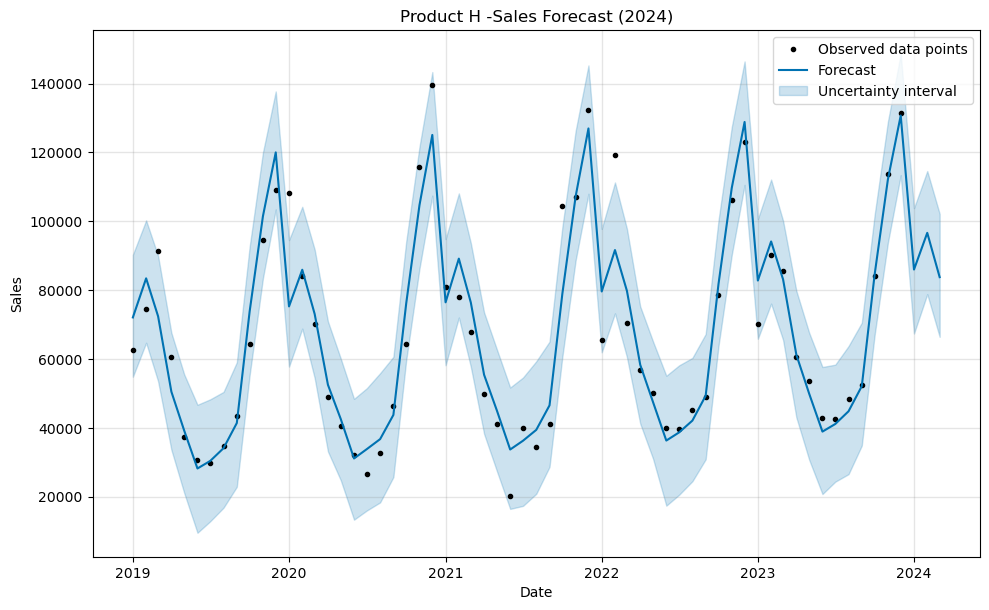

In [44]:
fig = model_forecast.plot(forecast_f, include_legend=True, uncertainty=True)
plt.title('Product H -Sales Forecast (2024)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [45]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model_forecast,forecast_f)

In [46]:
plot_components_plotly(model_forecast, forecast_f)